In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 50)

import torch
import torch.nn as nn

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import d2_absolute_error_score

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# plotting packages 
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import os
from termcolor import colored

# Opening file
file1 = open('C:\\Users\\matve\\Documents\\Python Scripts\\junior_quant_task\\train.txt', 'r')
count = 0
ob_num = 0
ob = [[0] * 3 for _ in range(40)]
ordbook = [[0] * 2 for _ in range(10000)]


for line in file1:
    if ("price" in line.strip()):
#         print(pd.DataFrame(data=ob))
        ob_num = 0
        ordbook[count][1] = tuple([x for x in line.strip().split(' price: ')])
        ordbook[count][0] = pd.DataFrame(data=ob)
        ordbook[count][0].columns = ['price','amount','side']
        count +=1
    elif not ("=" in line.strip()):
        line = line.strip().split('\t')
        ob[ob_num][0] = int(line[0])
        ob[ob_num][1] = int(line[1])
        ob[ob_num][2] = line[2]
        ob_num += 1
 
# Closing files
file1.close()

ordbook = [row for row in ordbook if row[1] != 0]


In [20]:
# FUNCTION FOR PLOTS
def OB_plot(lst, n_lst):
    num_plots = len(n_lst)
    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5))

    if num_plots == 1:
        axes = [axes]  # If there's only one plot, convert it to a list of length 1

    for i, n in enumerate(n_lst):
        obsample = lst[n][0]
        obprice = int(lst[n][1][1])
        axes[i].set_title('Order Book №' + str(n))
        
        sns.ecdfplot(x="price", weights="amount", stat="count", complementary=True, data=obsample[obsample.side == 'Buy'], ax=axes[i], color='g')
        sns.ecdfplot(x="price", weights="amount", stat="count", data=obsample[obsample.side == 'Sell'], ax=axes[i], color='r')
        axes[i].set_ylim(-5, max(lst[n][0]['amount'][21:].sum(), lst[n][0]['amount'][:20].sum()) + 180)
        
        l1 = axes[i].vlines(obprice, 0, max(lst[n][0]['amount'][21:].sum(), lst[n][0]['amount'][:20].sum()), color='black', ls='--', 
                            label=str(lst[n][1][0]).upper() + ' ' + str('{:_}'.format(int(lst[n][1][1]))))
        
        axes[i].text((lst[n][0]['price'][19] + lst[n][0]['price'][20]) / 2 - 20, 
                     max(lst[n][0]['amount'][21:].sum(), lst[n][0]['amount'][:20].sum()) + 100, 
                     'Spread = ' + str(lst[n][0]['price'][19] - lst[n][0]['price'][20]), fontsize=11, 
                     bbox=dict(facecolor='grey', alpha=0.2))
        axes[i].text(((lst[n][0]['price'][19] + lst[n][0]['price'][20])/2) - 30, 
                     max(lst[n][0]['amount'][21:].sum(), lst[n][0]['amount'][:20].sum()) + 25, 
                     'MidPrice =' + str('{:_}'.format(int((lst[n][0]['price'][19] + lst[n][0]['price'][20])/2))), fontsize=11, 
                     bbox=dict(facecolor='blue', alpha=0.2))
        
        axes[i].legend(fontsize=11)
        axes[i].set_xlabel("Modeled price - "+ str('{:_}'.format(int(app_func(lst, n)))))
        axes[i].set_ylabel("Coins amount")

    plt.tight_layout()  # Ensures that the subplots do not overlap
    plt.show()


In [21]:
# APROXIMATIG FUNCTION
def app_func(lst, n):
    
    ob = lst[n][0]
    
    direction = 1 if lst[n][1][0] == 'Sell' else -1
    mid_price = (ob['price'][19]+ob['price'][20])/2
    spread = (((ob['price'][19]-ob['price'][20])/ob['price'][19])**(-1))/7000
    ask_vol20 = ob['amount'][:20].sum()
    bid_vol20 = ob['amount'][20:].sum()
    ask_vol5 = ob['amount'][15:20].sum()
    bid_vol5 = ob['amount'][20:25].sum()
    ask_vol2 = ob['amount'][18:20].sum()
    bid_vol2 = ob['amount'][20:22].sum()
    ask_vol1 = ob['amount'][19:20].sum()
    bid_vol1 = ob['amount'][20:21].sum()
    
    return np.around((mid_price + 
                      direction*(0.2*(bid_vol1/ask_vol1)**direction+
                                  3*(bid_vol2/ask_vol2)**direction+
                                  1*(bid_vol5/ask_vol5)**direction+
                                  (bid_vol20/ask_vol20)**direction)+
                      spread**2)/5)*5

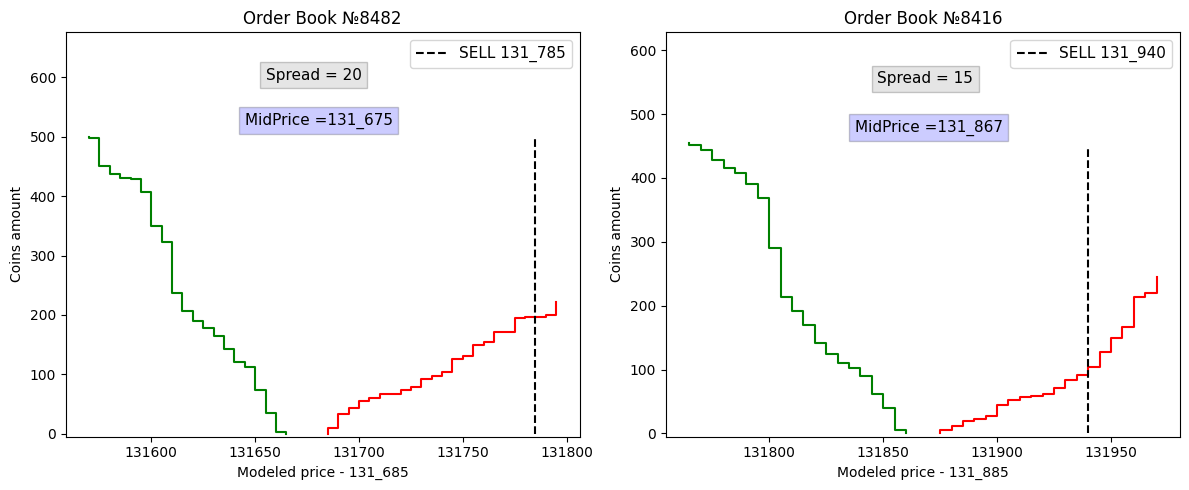

In [22]:
n = [8482,8416]
OB_plot(ordbook, n)

In [23]:
def preproc(df, order, price):
    direction = 1 if order == 'Sell' else -1
    
    df['quote'] = df['price']*df['amount']
    df['t'] = (-1)**(df['side']=='Buy')*df['price']
    df['lvl'] = df.groupby('side')['t'].rank().astype(int)
    
    df.drop('t', axis = 1, inplace = True)
    df = df.pivot(columns = 'side', index = 'lvl', values = ['quote', 'amount', 'price'])#.swaplevel(axis = 1)
    df[[('vol_cum', 'Buy'), ('vol_cum', 'Sell')]]= df[[('amount', 'Buy'), ('amount', 'Sell')]].cumsum()
#     df = df[['Buy', 'Sell']]

    cum_vol_frac = direction*(df['vol_cum', 'Buy']/df['vol_cum', 'Sell']).to_numpy()**direction
    
    vol_frac = direction*(df['amount', 'Buy']/df['amount', 'Sell']).to_numpy()**direction
    
    vol_prod = np.cumprod(vol_frac)

#     spread = df['price', 'Sell'][1]/(df['price', 'Sell'][1]-df['price', 'Buy'][1])
    
    spread = direction*((df['price', 'Sell'][1]/df['price', 'Buy'][1])-1)**(-1)
    midprice = (df['price', 'Sell'][1]+df['price', 'Buy'][1])/2
    
    return np.concatenate((vol_frac, cum_vol_frac,
           [np.prod(vol_frac),
            spread,
            float(price)-midprice]))

# preproc(ordbook[0][0], *ordbook[0][1])
# ordbook[0][1]

In [24]:
features = [preproc(ob.copy(), *com) for ob, com in ordbook]
features = np.array(features)
labels = np.array(features[:,-1])
features = features[:,:-1]

In [25]:
# print(ordbook[8482])
print(features[8482][20:40])
print(np.cumprod(features[8482][20:40]))
# print(labels)

[0.33333333 1.06060606 1.72093023 2.03636364 2.01666667 2.13432836
 2.24657534 2.28205128 2.06521739 2.13402062 2.30097087 2.55555556
 2.69230769 2.73154362 2.76774194 2.52046784 2.25257732 2.29591837
 2.49       2.24774775]
[3.33333333e-01 3.53535354e-01 6.08409678e-01 1.23894334e+00
 2.49853575e+00 5.33269569e+00 1.19803027e+01 2.73396650e+01
 5.64623517e+01 1.20491823e+02 2.77248175e+02 7.08523113e+02
 1.90756223e+03 5.21058944e+03 1.44215669e+04 3.63490955e+04
 8.18791481e+04 1.87987840e+05 4.68089722e+05 1.05214762e+06]


110
107
602.7661105567436


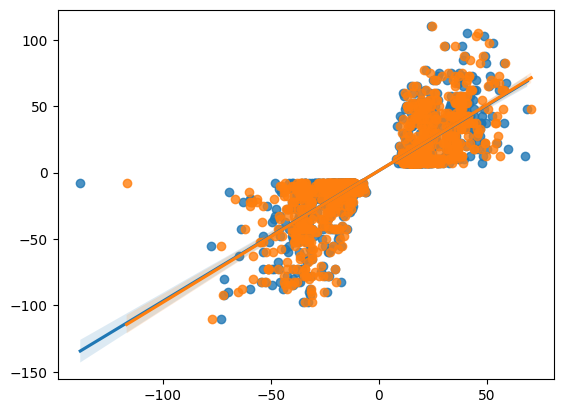

In [26]:
reg = LinearRegression()

lin = Lasso(alpha=0.0001,precompute=True,max_iter=100000, positive=True, random_state=9999, selection='random')

features_train = features[:8000]
labels_train = labels[:8000] 

features_test = features[8000:]
labels_test = labels[8000:] 

reg.fit(features_train, labels_train)
lin.fit(features_train, labels_train)

labels_pred_round_reg = reg.predict(features_test)
labels_pred_round_lin = lin.predict(features_test)

sns.regplot(x = labels_pred_round_reg, y = labels_test)
sns.regplot(x = labels_pred_round_lin, y = labels_test)
print(np.sum(np.around((labels_pred_round_lin - labels_test)/5) ==0))
print(np.sum(np.around((labels_pred_round_reg - labels_test)/5) ==0))


print(np.linalg.norm(labels_pred_round_reg - labels_test))

In [27]:
np.set_printoptions(suppress=True)
print(lin.coef_)
print(reg.coef_)

[0.         0.         0.18461008 0.07270105 0.17849993 0.07532212
 0.07742301 0.09252372 0.0875336  0.06214036 0.03383555 0.01801488
 0.01241902 0.01305475 0.02639571 0.02150428 0.         0.02962529
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.59498722 0.         0.049817   1.68182088 0.         0.32872592
 0.67282214 0.         1.7029506  0.42368346 0.         0.00109825]
[-0.0167922   0.11713689  0.23560786  0.10111205  0.30889469  0.0892999
  0.15906933  0.06126479 -0.00609626 -0.10366175  0.0491636  -0.02364955
 -0.04584493 -0.06492685  0.09745657  0.14143973  0.01568605  0.05649055
 -0.02376672 -0.00967176 -0.01134108 -0.08334282 -0.71444355 -0.07138075
 -0.01726557 -0.07475203 -0.06634371  0.04586282  0.1975279   0.32220827
  0.44564032  0.5311276   0.58109793  0.61280883  0.62666865  0.62299682
  0.61449723  0.60235324  0.57684538  0.54701989 -0.          0.00111784]


# Orderboor Research

In [1282]:
count=0
arg_spread_is_more_20 = []
for i in range(9000):
    if ordbook[i][0]['price'][19] - ordbook[i][0]['price'][20] > 35:
        arg_spread_is_more_20.append(i)
        print(i)
        if  (int(ordbook[i][1][1]) <= ordbook[i][0]['price'][19]) and (int(ordbook[i][1][1]) >= ordbook[i][0]['price'][20]):
            count +=1
print(count/len(arg_spread_is_more_20))

994
1173
3153
4004
4017
4021
4563
4564
5757
8631
8710
8808
0.9166666666666666


In [16]:
max_diff = 0
min_diff = 500

for i in range(9000):
    if ordbook[i][0]['price'][0] - ordbook[i][0]['price'][39] > max_diff:
        max_diff = ordbook[i][0]['price'][0] - ordbook[i][0]['price'][39]
    if ordbook[i][0]['price'][0] - ordbook[i][0]['price'][39] < min_diff:
        min_diff = ordbook[i][0]['price'][0] - ordbook[i][0]['price'][39]
        
print(max_diff/5)
print(min_diff/5)

62.0
39.0


482
24.366404348525407
110.0


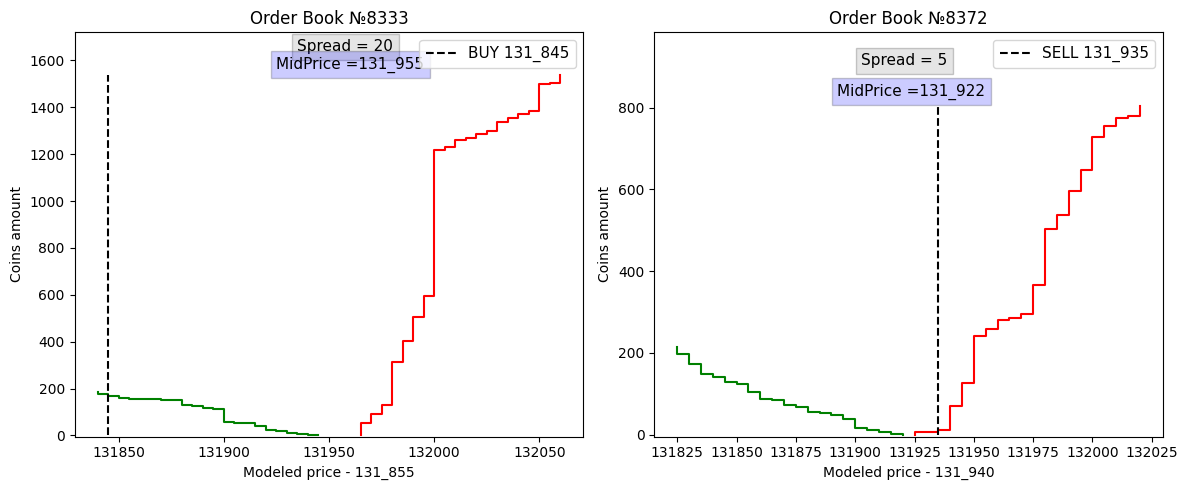

In [30]:
# 436 vs 8441 vs 696
# print(np.argmin(labels_pred_round_lin - labels_test))
print(np.min(482))
print(labels_pred_round_lin[482])
print(labels_test[482])
OB_plot(ordbook, [8333, 8372])
# OB_plot(ordbook, [8546,2173])

In [1197]:
print(labels_pred_round_reg)
print(labels_train)

[-1.29855777e+01  1.34684947e+01 -2.37944389e+01  9.32599964e+00
 -1.69700072e+01  1.53797842e+01 -1.54727467e+01  1.70337103e+01
 -1.20201776e+01  1.50543046e+01 -1.95844546e+01  1.04933959e+01
 -1.33819456e+01  1.09849809e+01 -2.51063029e+01  7.07969898e+00
 -3.86827814e+01  6.16961583e+00 -2.94904295e+01  1.49741606e+01
 -2.00720229e+01  1.73978826e+01 -3.01967295e+01  1.05825878e+01
 -2.09189204e+01  1.14844669e+01 -1.65647907e+01  1.20811146e+01
 -1.10440603e+01  2.22670739e+01 -1.03099199e+01  1.93345583e+01
 -1.00223638e+01  2.23695158e+01 -9.92751099e+00  2.30087582e+01
 -1.19786520e+01  2.27244416e+01 -8.77924435e+00  2.09477235e+01
 -1.02086303e+01  2.87135737e+01 -6.46747389e+00  1.93167859e+01
 -8.61279147e+00  2.43048180e+01 -8.20115716e+00  2.23662756e+01
  1.99593111e+01 -9.60943061e+00  1.51667166e+01 -1.07250665e+01
  1.58952892e+01 -1.86702525e+01  1.47080536e+01 -2.43351074e+01
  2.21576987e+01 -6.87715336e+00  2.85607758e+01 -2.76465681e+01
  1.43452793e+01 -1.93614

In [1207]:
def preproc(df, order, price):
# df, (order, price) = ordbook[3]

    direction = 1 if order == 'Sell' else -1

    df['quote'] = df['price']*df['amount']
    df['t'] = (-1)**(df['side']=='Buy')*df['price']
    df['lvl'] = df.groupby('side')['t'].rank().astype(int)

    df.drop('t', axis = 1, inplace = True)
    df = df.pivot(columns = 'side', index = 'lvl', values = ['quote', 'amount', 'price'])#.swaplevel(axis = 1)
    df[[('c_amount', 'Buy'), ('c_amount', 'Sell')]] = df[[('amount', 'Buy'), ('amount', 'Sell')]].cumsum()

    mid_price = (df['price', 'Sell'].loc[[1]]+df['price', 'Buy'].loc[[1]]).to_numpy()/2
    spread = (df['price', 'Sell'].loc[[1]]-df['price', 'Buy'].loc[[1]]).to_numpy()
    
    vol_frac = direction*(df['amount', 'Buy']/df['amount', 'Sell']).to_numpy()**direction
    
    vol_prod = np.cumprod(vol_frac)
    
    x = np.concatenate((spread, [order=='Sell'], vol_prod,
        (df['price'].loc[2:]-df['price'].loc[1].mean()).apply(np.abs).stack().to_numpy(),
        (df['c_amount', 'Sell']/df['c_amount', 'Buy']).apply(np.log).to_numpy(),
        df['c_amount'].apply(np.log).diff().dropna().stack().to_numpy()))

    y = np.abs(float(price)-mid_price)
    return x, y

# preproc(ordbook[0][0], *ordbook[0][1])
# ordbook[0][1]

In [1208]:
data = [preproc(ob.copy(), *com) for ob, com in ordbook]

In [1209]:
X, Y = zip(*data)
X = np.array(X)
Y = np.array(Y).reshape(-1)

In [1211]:
# RANDOM FOREST

reg = RandomForestRegressor(criterion = 'absolute_error', 
                            verbose = 10, 
#                             max_features = 'sqrt',
                            oob_score = d2_absolute_error_score,
                            n_jobs = -1,
                            n_estimators = 32)

reg.fit(X[:8000], Y[:8000])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 32building tree 2 of 32
building tree 3 of 32

building tree 4 of 32
building tree 5 of 32
building tree 6 of 32
building tree 7 of 32
building tree 8 of 32
building tree 9 of 32
building tree 10 of 32


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   36.5s


building tree 11 of 32
building tree 12 of 32
building tree 13 of 32
building tree 14 of 32
building tree 15 of 32
building tree 16 of 32
building tree 17 of 32


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min


building tree 18 of 32
building tree 19 of 32
building tree 20 of 32
building tree 21 of 32
building tree 22 of 32
building tree 23 of 32
building tree 24 of 32


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min


building tree 25 of 32
building tree 26 of 32
building tree 27 of 32
building tree 28 of 32
building tree 29 of 32


[Parallel(n_jobs=-1)]: Done  21 out of  32 | elapsed:  2.0min remaining:  1.0min


building tree 30 of 32
building tree 31 of 32
building tree 32 of 32


[Parallel(n_jobs=-1)]: Done  25 out of  32 | elapsed:  2.5min remaining:   42.4s
[Parallel(n_jobs=-1)]: Done  29 out of  32 | elapsed:  2.7min remaining:   16.9s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  3.0min finished


RandomForestRegressor(criterion='absolute_error', n_estimators=32, n_jobs=-1,
                      oob_score=<function d2_absolute_error_score at 0x000001788D1B35B0>,
                      verbose=10)

In [ ]:
np.linalg.norm(reg.predict(X[8000:])-Y[8000:])

In [1343]:
model = nn.Sequential(
    nn.Linear(118, 100),
    nn.ReLU(),
    nn.Linear(100, 80),
    nn.ReLU(),
    nn.Linear(80, 40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
)

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

In [1344]:
X_tensor = torch.tensor(X[:8000], dtype = torch.float)
y_tensor = torch.tensor(Y[:8000].reshape(-1, 1), dtype = torch.float)

In [1345]:
X_tensor.shape

torch.Size([8000, 118])

In [1347]:
loss_list = []
best_loss = 9000

for n in range(10000):
    y_pred = model(X_tensor)
    print(y_pred.detach().view(-1).numpy()[:5])
    loss = loss_fn(y_pred, y_tensor) 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if loss.detach().numpy() < best_loss:
        best_params = [x.detach().numpy() for x in model.parameters()]
        best_loss = loss.detach().numpy()
    
#     lbfgs.step(closure)
    
    loss_list.append(loss.detach().numpy())

[26789.508 26910.102 27121.727 43407.258 27102.518]
[26785.834 26906.037 27118.129 43401.16  27098.834]
[26761.645 26881.555 27093.855 43387.426 27074.762]
[26676.328 26796.482 27008.49  43306.27  26990.236]
[26555.387 26676.08  26887.598 43206.855 26870.354]
[26452.559 26573.791 26784.912 43150.91  26768.56 ]
[26427.87  26549.068 26760.373 43180.168 26744.193]
[26438.582 26559.176 26771.031 43254.395 26754.777]
[26440.525 26560.58  26772.98  43308.844 26756.482]
[26377.438 26497.402 26709.803 43232.875 26693.92 ]
[26240.857 26361.807 26573.44  43057.938 26558.768]
[26131.012 26252.52  26463.691 42959.793 26449.98 ]
[26072.262 26193.814 26404.92  42978.6   26391.725]
[26112.984 26233.965 26445.703 43020.324 26432.133]
[26475.668 26595.162 26808.395 43155.97  26792.781]
[26585.588 26700.326 26913.484 42900.28  26898.902]
[25557.125 25663.213 25872.24  42281.99  25867.545]
[23069.65  23166.111 23365.936 41117.527 23381.836]
[20048.611 20135.908 20325.475 39366.938 20365.135]
[17954.297 1

KeyboardInterrupt: 

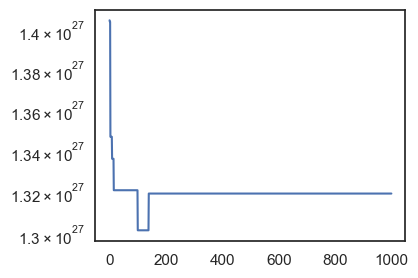

In [1312]:
plt.plot(np.array(loss_list).reshape(-1))
plt.yscale('log')
plt.show()

In [1180]:
print(np.array(loss_list).reshape(-1)[-1]/9000)
print(np.min(loss_list)/9000)
print(best_loss/9000)

42.560350694444445
42.560350694444445
1.0


In [ ]:
model(X_tensor)-y_tensor

In [739]:
minl = []

for n in range(9000):
# n=10
    df = ordbook[n][0].copy()
    order, price = ordbook[n][1]
    price = int(price)

    df['quote'] = df['price']*df['amount']
    df['t'] = (-1)**(df['side']=='Buy')*df['price']
    df.set_index('side', inplace = True)

    df = df.groupby(level = 0).apply(lambda t: t.sort_values(by = 't')).drop('t', axis = 1).droplevel(0)
    df['C'] = df['amount']+1j*df['quote']/1e+5
    df['D'] = df.groupby(level = 0)['C'].apply(lambda t: t.cumsum()).droplevel(0)
    df['F'] = df['D'].apply(lambda x: np.tan(np.angle(x)))

    df['G'] = (-1)**(df.index.to_series()=='Buy')*df['D']

    # if order=='Buy':
    #     df['Z'] = (df['price']>=price)
    # else:
    #     df['Z'] = (df['price']<=price)

    #     print(order)
    #     print(price)

    df = df.sort_values('price', ascending = False)

    G = df['G'].to_numpy()
    G_re, G_im = np.real(G), np.imag(G)
    # G_f = interp1d(G_re, G_im, kind='linear')
    G_f = interp1d(G_im, G_re, kind='linear')

    l, r = np.min(G_im), np.max(G_im)
    x = np.linspace(l, r, 200)
    # y = G_f(x)-price/1e+5*x
    y = G_f(x)-1e+5*x/price

#     plt.plot(x, y)
#     plt.show()
#     print(y)

    minl.append((order, np.max(y), x[np.argmax(y)], l, r))
    print(minl[-1])

NameError: name 'interp1d' is not defined

In [1231]:
pd.DataFrame(minl)

,0,1,2,3,4
0,Buy,-0.0037,-43.427136,-383.0,412.0


In [1148]:
# np.tan(np.angle(df['C'].iloc[5:35].sum()))

In [1147]:
# ordbook[n][1]

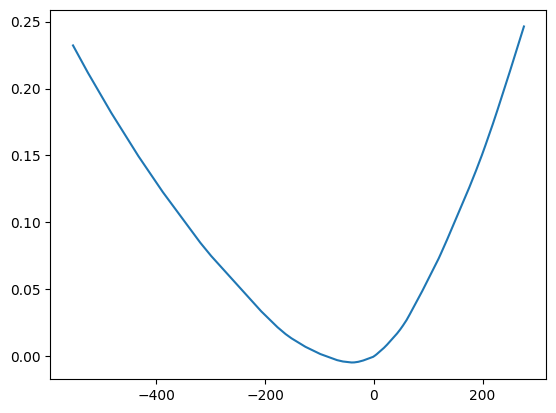

In [1211]:
G = df['G'].to_numpy()
G_re, G_im = np.real(G), np.imag(G)
G_f = interp1d(G_re, G_im, kind='linear')

l, r = np.min(G_re), np.max(G_re)
x = np.linspace(l, r, 1000)
y = G_f(x)-price/1e+5*x
plt.plot(x, y)

In [1207]:
print(np.min(y))
print(x[np.argmin(y)])

-5.0000000002548006e-05
-5.758758758758745


In [1212]:
print(np.min(y))
print(x[np.argmin(y)])

-0.004500000000007276
-41.82482482482487


In [1089]:
from scipy.interpolate import interp1d

f = interp1d(np.concatenate([[0], np.real(a)]), np.concatenate([[0], np.imag(a)]), kind='linear')
g = interp1d(np.concatenate([[0], np.real(b)]), np.concatenate([[0], np.imag(b)]), kind='linear')

In [1090]:
f(np.linspace(0, 380, 1000))-g(np.linspace(0, 380, 1000))

array([0.00000000e+00, 5.70570571e-05, 1.14114114e-04, 1.71171171e-04,
       2.28228228e-04, 2.85285285e-04, 3.42342342e-04, 3.99399399e-04,
       4.56456456e-04, 5.13513514e-04, 5.70570571e-04, 6.36836837e-04,
       7.12912913e-04, 7.88988989e-04, 8.65065065e-04, 9.41141141e-04,
       1.01721722e-03, 1.09329329e-03, 1.16936937e-03, 1.24544545e-03,
       1.32152152e-03, 1.39759760e-03, 1.47367367e-03, 1.54974975e-03,
       1.62582583e-03, 1.70190190e-03, 1.77797798e-03, 1.85405405e-03,
       1.93013013e-03, 2.00620621e-03, 2.08228228e-03, 2.15835836e-03,
       2.23443443e-03, 2.31051051e-03, 2.38658659e-03, 2.47832833e-03,
       2.57342342e-03, 2.67222222e-03, 2.78633634e-03, 2.90045045e-03,
       3.01456456e-03, 3.12867868e-03, 3.24279279e-03, 3.35690691e-03,
       3.47102102e-03, 3.58513514e-03, 3.69924925e-03, 3.81336336e-03,
       3.92747748e-03, 4.04159159e-03, 4.15570571e-03, 4.26981982e-03,
       4.38393393e-03, 4.49804805e-03, 4.61216216e-03, 4.72627628e-03,
      

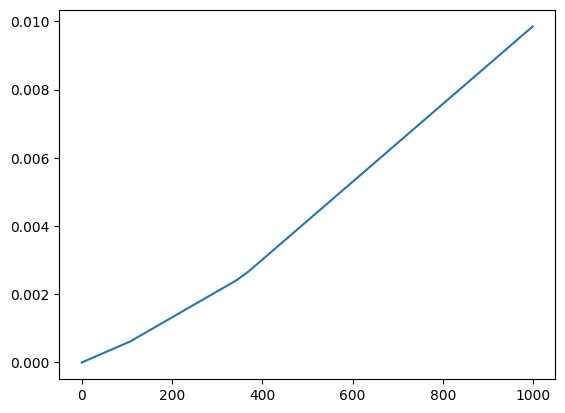

In [1091]:
plt.plot(f(np.linspace(0, 38, 1000))-g(np.linspace(0, 38, 1000)))

In [1242]:
y = np.array([int(ordbook[i][1][1]) for i in range(9000)])
X = pd.concat([ordbook[i][0]['amount'] for i in range(9000)], axis = 1).T.reset_index(drop = True)
X1 = pd.concat([ordbook[i][0]['price'] for i in range(9000)], axis = 1).T.reset_index(drop = True)

X = pd.concat({'v':X, 'p':X1}, axis = 1)
X.columns = ['{}_{}'.format(*x) for x in X.columns]
X['m'] = (y>=X['p_19']).astype(int)

del X1
y

array([130895, 130900, 130940, ..., 131535, 131595, 131560])

In [1243]:
(y.max() - y.min())/5

438.0

In [1170]:
X_train = X[:8000]
y_train = y[:8000]

In [1175]:
model(X_tensor)

tensor([[-9578.3506],
        [-9583.1338],
        [-9587.1689],
        ...,
        [-9664.7178],
        [-9666.2031],
        [-9665.7500]], grad_fn=<AddmmBackward0>)

In [826]:
list((model(torch.tensor(X[8000:].to_numpy(), dtype = torch.float))-torch.tensor(y[8000:].reshape(-1, 1), dtype = torch.float)).detach().numpy())

[array([42.34375], dtype=float32),
 array([-12.703125], dtype=float32),
 array([4.859375], dtype=float32),
 array([-10.671875], dtype=float32),
 array([12.828125], dtype=float32),
 array([-9.296875], dtype=float32),
 array([10.84375], dtype=float32),
 array([-36.546875], dtype=float32),
 array([24.359375], dtype=float32),
 array([-31.53125], dtype=float32),
 array([8.75], dtype=float32),
 array([-13.40625], dtype=float32),
 array([10.078125], dtype=float32),
 array([-22.4375], dtype=float32),
 array([23.03125], dtype=float32),
 array([-15.3125], dtype=float32),
 array([26.96875], dtype=float32),
 array([-41.8125], dtype=float32),
 array([8.375], dtype=float32),
 array([-11.234375], dtype=float32),
 array([8.484375], dtype=float32),
 array([-12.609375], dtype=float32),
 array([6.28125], dtype=float32),
 array([-7.328125], dtype=float32),
 array([7.25], dtype=float32),
 array([-7.609375], dtype=float32),
 array([9.25], dtype=float32),
 array([-7.125], dtype=float32),
 array([18.234375], 

In [401]:
model(X_tensor)-y_tensor

tensor([[1825.4844],
        [-685.6172],
        [3377.3750],
        ...,
        [-392.5469],
        [-690.6016],
        [ 641.2812]], grad_fn=<SubBackward0>)

In [196]:
model(X_tensor)

tensor([[125344.2656],
        [134250.3125],
        [126799.6016],
        ...,
        [162165.0469],
        [163895.3906],
        [161510.5156]], grad_fn=<AddmmBackward0>)

In [19]:
levels = (X1==y.reshape(-1, 1)).astype(int)
levels.columns = range(1,41)

levels["up"] = pd.DataFrame(np.zeros((9000, 1))).astype(int)
levels["down"] = pd.DataFrame(np.zeros((9000, 1))).astype(int)
levels["spread"] = pd.DataFrame(np.zeros((9000, 1))).astype(int)

levels["up"] = (X1[0]<y).astype(int)
levels["down"] = (X1[39]>y).astype(int)
levels["spread"] = ((X1[19]>y) & (X1[20]<y)).astype(int)

print(levels["up"].sum())
print(levels["down"].sum())
print(levels["spread"].sum())

X1

0
0
136


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,130990,130985,130980,130975,130970,130965,130960,130955,130950,130945,130940,130935,130930,130925,130920,130915,130910,130905,130900,130895,130880,130875,130870,130865,130860,130855,130850,130845,130840,130835,130830,130825,130820,130815,130810,130805,130800,130795,130790,130785
1,130995,130990,130985,130980,130975,130970,130965,130960,130955,130950,130945,130940,130935,130930,130925,130920,130915,130910,130905,130900,130885,130880,130875,130870,130865,130860,130855,130850,130845,130840,130835,130830,130825,130820,130815,130810,130805,130800,130795,130790
2,131030,131025,131020,131015,131010,131005,131000,130995,130990,130985,130980,130975,130970,130965,130960,130955,130950,130945,130940,130935,130920,130915,130910,130905,130900,130895,130890,130885,130880,130875,130870,130865,130860,130855,130850,130845,130840,130835,130830,130825
3,131045,131040,131035,131030,131025,131020,131015,131010,131005,131000,130995,130990,130985,130980,130975,130970,130965,130960,130955,130950,130940,130935,130930,130925,130920,130915,130905,130900,130895,130890,130885,130880,130875,130870,130865,130860,130855,130850,130845,130840
4,131035,131030,131025,131020,131015,131010,131005,131000,130995,130990,130985,130980,130975,130970,130965,130960,130955,130950,130945,130940,130935,130920,130915,130910,130905,130900,130895,130890,130885,130880,130875,130870,130865,130860,130855,130850,130845,130840,130835,130830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,131695,131690,131685,131680,131675,131670,131665,131660,131655,131650,131645,131640,131635,131630,131625,131620,131615,131610,131605,131600,131590,131580,131575,131570,131565,131560,131555,131550,131545,131540,131535,131530,131525,131520,131515,131510,131505,131500,131495,131490
8996,131680,131675,131670,131665,131660,131655,131650,131645,131640,131635,131630,131625,131620,131615,131610,131605,131600,131595,131590,131585,131565,131560,131555,131550,131545,131540,131535,131530,131525,131520,131515,131510,131505,131500,131495,131490,131485,131480,131475,131470
8997,131675,131670,131665,131660,131655,131650,131645,131640,131635,131630,131625,131620,131615,131610,131605,131600,131595,131590,131585,131575,131570,131565,131560,131555,131550,131545,131540,131535,131530,131525,131520,131515,131510,131505,131500,131495,131490,131485,131480,131475
8998,131675,131670,131665,131660,131655,131650,131645,131640,131635,131630,131625,131620,131615,131610,131605,131600,131595,131590,131585,131580,131570,131565,131560,131555,131550,131545,131540,131535,131530,131525,131520,131515,131510,131505,131500,131495,131490,131485,131480,131475


In [20]:
X['spread'] = X1[19]-X1[20]
X['best_bid'], X['best_ask'] = X1[20], X1[19]

In [21]:
X['is_sell'] = (y>=X['best_ask']).astype(int)

In [23]:
X.columns = range(len(X.columns))

In [24]:
reg = LinearRegression()

reg.fit(X.iloc[:8000], y[:8000])

LinearRegression()

1000

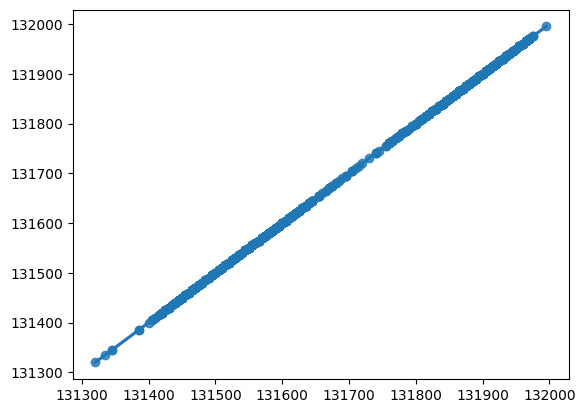

In [25]:
y_pred_round = np.around(reg.predict(X.iloc[8000:])/5)*5
y_test = y[8000:]

sns.regplot(x = y_pred_round, y = y[8000:])
np.sum(y_pred_round == y_test)

In [12]:
# !pip install LightGBM

In [13]:
from lightgbm import LGBMRegressor

In [960]:
y = np.array([ordbook[i][1] for i in range(9000)])
X = pd.concat([ordbook[i][0]['amount'] for i in range(9000)], axis = 1).T.reset_index(drop = True)
X1 = pd.concat([ordbook[i][0]['price'] for i in range(9000)], axis = 1).T.reset_index(drop = True)
X2 = pd.concat([np.log(ordbook[i][0]['price']*ordbook[i][0]['amount']) for i in range(9000)], axis = 1).T.reset_index(drop = True)


X = pd.concat({'v':X, 'p':X1, 'ln_qv':X2}, axis = 1)
X.columns = ['{}_{}'.format(*x) for x in X.columns]
X['m'] = (y>=X['p_19']).astype(int)
X['mid_price'] = (X['p_19'] + X['p_20']) / 2

del X1
X

,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,v_15,v_16,v_17,v_18,v_19,v_20,v_21,v_22,v_23,v_24,...,ln_qv_17,ln_qv_18,ln_qv_19,ln_qv_20,ln_qv_21,ln_qv_22,ln_qv_23,ln_qv_24,ln_qv_25,ln_qv_26,ln_qv_27,ln_qv_28,ln_qv_29,ln_qv_30,ln_qv_31,ln_qv_32,ln_qv_33,ln_qv_34,ln_qv_35,ln_qv_36,ln_qv_37,ln_qv_38,ln_qv_39,m,mid_price
0,41,16,22,18,13,13,8,21,43,20,31,10,5,12,4,8,6,111,32,14,4,9,52,6,8,...,16.491757,15.247925,14.421208,13.168331,13.979223,15.733203,13.573681,13.861325,15.114050,14.872849,15.182966,14.872773,14.726131,14.872697,14.872658,16.345926,14.777272,15.693524,15.565653,15.610066,15.631534,15.215335,14.346259,1,130887.5
1,34,22,4,10,26,11,22,21,11,57,23,17,12,5,15,11,14,14,46,25,8,8,13,18,4,...,14.421323,15.610869,15.001065,13.861516,13.861478,14.346947,14.672332,13.168216,14.084468,14.959899,15.278314,14.179664,14.554319,14.726131,15.148950,14.917110,16.258914,14.614753,15.788834,15.652664,15.610066,15.751678,15.000224,1,130892.5
2,11,11,42,15,43,20,83,38,27,15,8,14,18,22,11,12,6,25,1,4,5,7,1,8,35,...,15.001408,11.782494,13.168751,13.391780,13.728214,11.782265,13.861669,15.337537,14.084736,12.880725,14.873117,14.672408,14.266905,13.573719,14.917416,14.672255,15.247581,16.236154,14.489819,15.182928,14.266599,13.861096,13.978840,1,130927.5
3,19,5,3,11,11,43,15,43,22,84,35,27,13,6,13,17,21,14,10,2,1,23,2,6,5,...,14.421705,14.085194,12.475718,11.782494,14.917951,12.475565,13.574139,13.391780,14.347253,15.393145,15.337537,14.347100,12.880725,14.873117,15.077873,14.266905,13.861401,14.872964,14.726322,15.183043,16.224458,14.489819,15.039827,0,130945.0
4,3,11,11,43,15,43,22,87,36,27,12,10,10,14,15,18,10,5,2,31,5,3,5,9,50,...,13.392009,12.475680,15.216482,13.391894,12.880954,13.391741,13.979490,15.694250,15.337537,13.979375,12.880725,14.873117,15.216023,14.266905,13.861401,14.872964,14.726322,15.114050,16.072266,14.489819,15.039827,14.554281,13.861096,1,130937.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,45,29,63,49,26,25,31,29,37,64,45,28,8,37,31,20,11,10,9,1,1,2,8,13,1,...,14.090183,13.984785,11.787522,11.787446,12.480517,13.866774,14.352244,11.787256,14.272125,14.677552,14.620356,15.398022,14.271973,14.922522,15.571180,16.035447,15.500486,14.184771,16.411811,14.089385,16.252670,15.044821,14.184581,0,131595.0
8996,36,26,23,45,29,24,47,58,34,9,38,24,26,15,15,9,10,10,15,16,1,57,23,23,35,...,14.090069,14.495497,14.559997,11.787256,15.830270,14.922675,14.922637,15.342452,14.731505,14.351978,15.571180,15.658153,15.450476,14.620090,16.582629,14.922294,16.156210,14.922218,14.964740,15.450210,13.396048,13.578331,13.172828,1,131575.0
8997,26,23,48,29,24,50,58,34,10,39,28,24,14,14,8,12,13,16,9,12,1,2,52,17,13,...,14.560035,13.984633,14.272239,11.787294,12.480403,15.738462,14.620394,14.352092,15.450666,15.082903,14.351978,15.658191,15.914087,15.658115,14.271783,16.496368,14.922294,16.156210,14.831247,15.005562,15.475528,13.396048,13.578331,0,131572.5
8998,26,23,35,29,24,50,70,24,6,51,27,13,7,21,10,16,7,8,14,12,3,3,3,18,24,...,13.866888,14.426466,14.272277,12.885907,12.885869,12.885831,14.677552,14.965196,15.313465,14.731505,14.831551,15.342338,15.881297,15.424500,14.184771,16.514226,14.877843,16.156210,14.831247,14.425743,15.118853,14.676982,13.578331,1,131575.0


In [961]:
reg = LGBMRegressor()

reg.fit(X.iloc[:8000], y[:8000])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27155
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 122
[LightGBM] [Info] Start training from score 131286.212500


LGBMRegressor()

104

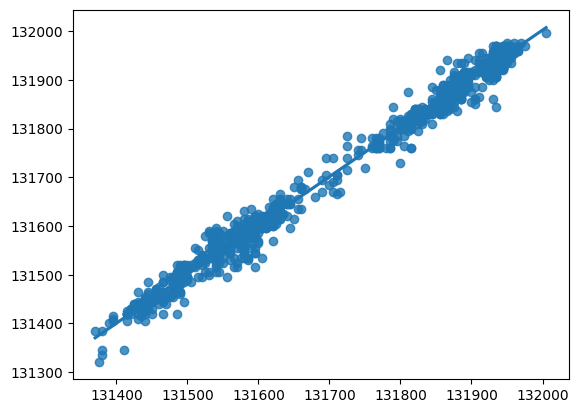

In [963]:
# Check for 
y_pred_round = np.around(reg.predict(X.iloc[8000:])/5)*5
y_test = y[8000:]

sns.regplot(x = y_pred_round, y = y[8000:])
np.sum(y_pred_round == y_test)

In [1116]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[50, 75, 100, 150, 200], 'learning_rate':[0.2, 0.15, 0.1, 0.07, 0.05], 'num_leaves' : [15, 31, 63, 127], 'max_depth':[-1, 4, 5, 6,10]}
reg = LGBMRegressor(objective = 'regression')

gs = GridSearchCV(reg, params, scoring = 'r2', verbose = 10)
gs.fit(X, y)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV 1/5; 1/500] START learning_rate=0.2, max_depth=-1, n_estimators=50, num_leaves=15
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26845
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 122
[LightGBM] [Info] Start training from score 131508.566667
[CV 1/5; 1/500] END learning_rate=0.2, max_depth=-1, n_estimators=50, num_leaves=15;, score=0.957 total time=   0.3s
[CV 2/5; 1/500] START learning_rate=0.2, max_depth=-1, n_estimators=50, num_leaves=15
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26783
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 122
[LightGBM

KeyboardInterrupt: 

In [1117]:
print(gs.best_score_)
print(gs.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

0.176

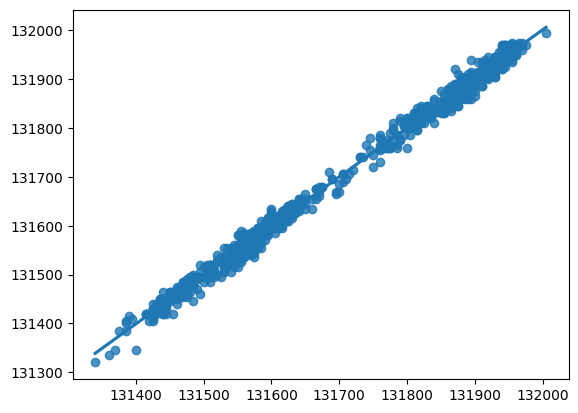

In [1114]:
y_pred_round = np.around(gs.best_estimator_.predict(X.iloc[8000:])/5)*5
y_test = y[8000:]

sns.regplot(x = y_pred_round, y = y[8000:])
np.sum(y_pred_round == y_test)/len(y_pred_round)

In [1112]:
gs.best_estimator_.predict(X.iloc[8000:])/5

array([26374.97022883, 26383.60382172, 26375.67375537, 26385.56500147,
       26374.92280391, 26383.79099017, 26375.54746614, 26383.9975228 ,
       26374.83893636, 26386.4333531 , 26380.9350702 , 26387.18414778,
       26377.09191098, 26387.55934663, 26377.52912652, 26392.28096764,
       26377.46234585, 26389.5494872 , 26379.24026286, 26388.4164687 ,
       26375.51284141, 26388.42424092, 26380.6835262 , 26384.30822394,
       26376.01354157, 26385.15273358, 26378.08859296, 26384.03582221,
       26376.52450343, 26388.21631199, 26378.63319359, 26387.64818054,
       26378.15305624, 26389.1306005 , 26377.7442579 , 26385.98310715,
       26375.3246406 , 26385.74109472, 26374.78524424, 26387.02032227,
       26373.63907599, 26383.21719233, 26373.8411472 , 26384.00353968,
       26375.12138088, 26381.74702857, 26375.82263904, 26382.28975045,
       26385.05751477, 26374.66632091, 26385.03237039, 26376.28616836,
       26385.59821545, 26374.5644666 , 26386.99348725, 26377.47304813,
      

In [1113]:
np.around(gs.best_estimator_.predict(X.iloc[8000:])/5)

array([26375., 26384., 26376., 26386., 26375., 26384., 26376., 26384.,
       26375., 26386., 26381., 26387., 26377., 26388., 26378., 26392.,
       26377., 26390., 26379., 26388., 26376., 26388., 26381., 26384.,
       26376., 26385., 26378., 26384., 26377., 26388., 26379., 26388.,
       26378., 26389., 26378., 26386., 26375., 26386., 26375., 26387.,
       26374., 26383., 26374., 26384., 26375., 26382., 26376., 26382.,
       26385., 26375., 26385., 26376., 26386., 26375., 26387., 26377.,
       26389., 26376., 26385., 26378., 26388., 26378., 26387., 26379.,
       26388., 26379., 26387., 26378., 26387., 26385., 26380., 26389.,
       26381., 26388., 26387., 26392., 26383., 26390., 26384., 26392.,
       26383., 26391., 26381., 26391., 26382., 26392., 26382., 26389.,
       26380., 26386., 26379., 26388., 26380., 26387., 26378., 26390.,
       26379., 26388., 26379., 26389., 26380., 26389., 26378., 26388.,
       26378., 26388., 26378., 26387., 26378., 26389., 26375., 26389.,
      